# Train a new model

In this notebook we will learn how to train a new model for axon & myelin segmentation. It covers the following scenario:

* Train a model from scratch by defining the parameters of the network
* Make inference using the trained model


In [81]:
import json
import os
import time
import tensorflow as tf
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import imageio
import matplotlib.pyplot as plt
from shutil import copy
import zipfile
from tqdm import tqdm
import cgi
import tempfile
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util import Retry

from AxonDeepSeg.train_network import train_model
from AxonDeepSeg.apply_model import axon_segmentation

# reset the tensorflow graph for new training
tf.reset_default_graph()

%matplotlib inline

### 0. Download example data

In [97]:
url_example_data = "https://osf.io/uw5hv/?action=download"  # URL of example data hosted on OSF
file_data = "TEM_striatum.zip"

# Download
try:
    print('Trying URL: %s' % url_example_data)
    retry = Retry(total=3, backoff_factor=0.5, status_forcelist=[500, 503, 504])
    session = requests.Session()
    session.mount('https://', HTTPAdapter(max_retries=retry))
    response = session.get(url_example_data, stream=True)
    tmp_path = os.path.join(tempfile.mkdtemp(), filename)
    with open(tmp_path, 'wb') as tmp_file:
        total = int(response.headers.get('content-length', 1))
        tqdm_bar = tqdm(total=total, unit='B', unit_scale=True, desc="Downloading", ascii=True)
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                tmp_file.write(chunk)
                dl_chunk = len(chunk)
                tqdm_bar.update(dl_chunk)
        tqdm_bar.close()
except Exception as e:
    print("ERROR: %s" % e)

    # Unzip
print("Unzip...")
try:
    zf = zipfile.ZipFile(tmp_path)
    zf.extractall(".")
except (zipfile.BadZipfile):
    print('ERROR: ZIP package corrupted. Please try downloading again.')
print("--> Folder created: " + os.path.join(os.path.abspath(os.curdir), file_data.strip(".zip")))

Trying URL: https://osf.io/uw5hv/?action=download




Downloading:   0%|          | 0.00/12.3M [00:00<?, ?B/s]

Downloading:   6%|5         | 680k/12.3M [00:00<00:01, 6.79MB/s]

Downloading:  15%|#4        | 1.84M/12.3M [00:00<00:01, 7.75MB/s]

Downloading:  24%|##4       | 3.01M/12.3M [00:00<00:01, 8.60MB/s]

Downloading:  34%|###4      | 4.19M/12.3M [00:00<00:00, 9.35MB/s]

Downloading:  44%|####3     | 5.37M/12.3M [00:00<00:00, 9.95MB/s]

Downloading:  53%|#####3    | 6.55M/12.3M [00:00<00:00, 10.4MB/s]

Downloading:  63%|######2   | 7.73M/12.3M [00:00<00:00, 10.8MB/s]

Downloading:  72%|#######2  | 8.90M/12.3M [00:00<00:00, 11.0MB/s]

Downloading:  82%|########1 | 10.1M/12.3M [00:00<00:00, 11.2MB/s]

Downloading:  92%|#########1| 11.3M/12.3M [00:01<00:00, 11.4MB/s]

Downloading: 100%|##########| 12.3M/12.3M [00:01<00:00, 11.2MB/s]

Unzip...
--> Folder created: /home/neuropoly/axondeepseg/notebooks/TEM_striatum


### 1. Train a new model
#### 1.1. Create subfolder to save new model and its parameters.

For simplicity, the new model will be created under the `models/` folder in the AxonDeepSeg repository. The name of the model folder will be generated automatically using the date and time (to avoid multiple instances).

In [100]:
# Define path to where the trained model will be saved
dir_name = time.strftime("%Y-%m-%d") + '_' + time.strftime("%H-%M-%S")
path_model = os.path.join('../models/', dir_name)

# Create directory
if not os.path.exists(path_model):
    os.makedirs(path_model)

file_config = 'config_network.json'  # file name of network configuration

#### 1.2. Define the name and path of the training set

Here we assume that the training data folder has already been created by following the guidelines detailed in [guide_dataset_building.ipynb](https://github.com/neuropoly/axondeepseg/blob/master/notebooks/guide_dataset_building.ipynb).

The expected structure of the training data folder is the following:

~~~
data
 └── Train
      └── image_0.png
      └── mask_0.png
      └── image_1.png
      └── mask_1.png
          ...
 └── Validation
      └── image_0.png
      └── mask_0.png
      └── image_1.png
      └── mask_1.png
          ...
~~~

In [101]:
trainingset_name = 'TEM_3c_512'
path_training = './TEM_striatum/data'  #  folder containing training data
# path_training = '/home/neuropoly/mikula/data/patched_data'  #  folder containing training data

#### 1.3. Define the configuration parameters of the training

The networks and training parameters (i.e. hyperparameters) used in the original [AxonDeepSeg article](https://www.nature.com/articles/s41598-018-22181-4) are defined below for TEM and SEM. **Note that these architectures might not produce satisfactory results on your data.**

Importantly: the pixel size is not defined at the training step. During inference however, the parameter `-t {SEM,TEM}` sets the resampling resolution to 0.1µm or 0.01µm respectively (i.e., implying the pixel size of the training data is 0.1µm or 0.01µm respectively). This is definitely a limitation of the current version of AxonDeepSeg, which we are planning to solve at some point (for more info, see [Issue #152](https://github.com/neuropoly/axondeepseg/issues/152)). 

In [102]:
# Example of network configuration for TEM data
config = {
    
# General parameters:    
  "n_classes": 3,  # Number of classes. For this application, the number of classes should be set to **3** (i.e. axon pixel, myelin pixel, or background pixel).
  "thresholds": [0, 0.2, 0.8],  # Thresholds for the 3-class classification problem. Do not modify.  
  "trainingset_patchsize": 512,  # Patch size of the training set in pixels (note that the patches have the same size in both dimensions).  
  "trainingset": trainingset_name,  # Name of the training set.
  "batch_size": 8,  # Batch size, i.e. the number of training patches used in one iteration of the training. Note that a larger batch size will take more memory.

# Network architecture parameters:     
  "depth": 4,  # Depth of the network (i.e. number of blocks of the U-net).
  "convolution_per_layer": [3, 3, 3, 3],  # Number of convolution layers used at each block.
  "size_of_convolutions_per_layer": [[5, 5, 5], [3, 3, 3], [3, 3, 3], [3, 3, 3]],  # Kernel size of each convolution layer of the network.
  "features_per_convolution": [[[1, 16], [16, 16], [16, 16]], [[16, 32], [32, 32], [32, 32]], [[32, 64], [64, 64], [64, 64]], [[64, 128], [128, 128], [128, 128]]],  # Number of features of each convolution layer.
  "downsampling": "convolution",  # Type of downsampling to use in the downsampling layers of the network. Option "maxpooling" for standard max pooling layer or option "convolution" for learned convolutional downsampling.
  "dropout": 0.75,  # Dropout to use for the training. Note: In TensorFlow, the keep probability is used instead. For instance, setting this param. to 0.75 means that 75% of the neurons of the network will be kept (i.e. dropout of 25%).
     
# Learning rate parameters:    
  "learning_rate": 0.001,  # Learning rate to use in the training.  
  "learning_rate_decay_activate": True,  # Set to "True" to use a decay on the learning rate.  
  "learning_rate_decay_period": 24000,  # Period of the learning rate decay, expressed in number of images (samples) seen.
  "learning_rate_decay_type": "polynomial",  # Type of decay to use. An exponential decay will be used by default unless this param. is set to "polynomial" (to use a polynomial decay).
  "learning_rate_decay_rate": 0.99,  # Rate of the decay to use for the exponential decay. This only applies when the user does not set the decay type to "polynomial".
    
# Batch normalization parameters:     
  "batch_norm_activate": True,  # Set to "True" to use batch normalization during the training.
  "batch_norm_decay_decay_activate": True,  # Set to "True" to activate an exponential decay for the batch normalization step of the training.  
  "batch_norm_decay_starting_decay": 0.7,  # The starting decay value for the batch normalization. 
  "batch_norm_decay_ending_decay": 0.9,  # The ending decay value for the batch normalization.
  "batch_norm_decay_decay_period": 16000,  # Period of the batch normalization decay, expressed in number of images (samples) seen.
        
# Weighted cost parameters:    
  "weighted_cost-activate": True,  # Set to "True" to use weights based on the class in the cost function for the training.
  "weighted_cost-balanced_activate": True,  # Set to "True" to use weights in the cost function to correct class imbalance. 
  "weighted_cost-balanced_weights": [1.1, 1, 1.3],  # Values of the weights for the class imbalance. Typically, larger weights are assigned to classes with less pixels to add more penalty in the cost function when there is a misclassification. Order of the classes in the weights list: background, myelin, axon.
  "weighted_cost-boundaries_sigma": 2,  # Set to "True" to add weights to the boundaries (e.g. penalize more when misclassification happens in the axon-myelin interface).
  "weighted_cost-boundaries_activate": False,  # Value to control the distribution of the boundary weights (if activated). 
    
# Data augmentation parameters:
# For each type of data augmentation, the order needs to be specified if you decide to apply more than one 
# transformation sequentially. For instance, setting the "da-0-shifting-activate" parameter to 'True' means that the 
# shifting is the first transformation that will be applied to the sample(s) during training. The default ranges of 
# transformations are:
#   Shifing: Random horizontal and vertical shifting between 0 and 10% of the patch size, sampled from a uniform distribution.
#   Rotation: Random rotation, angle between 5 and 89 degrees, sampled from a uniform distribution.
#   Rescaling: Random rescaling of a randomly sampled factor between 1/1.2 and 1.2.
#   Flipping: Random fipping: vertical fipping or horizontal fipping.
#   Blurring: Gaussian blur with the standard deviation of the gaussian kernel being uniformly sampled between 0 and 4.
#   Elastic deformation: Random elastic deformation with uniformly sampled deformation coefficient α=[1–8] and fixed standard deviation σ=4.
# You can find more information about the range of transformations applied to the patches for each data augmentation technique in the file "data_augmentation.py".
  "da-type": "all",  # Type of data augmentation procedure. Option **"all"** applies all selected data augmentation transformations sequentially, while option **"random"** only applies one of the selected transformations (randomly) to the sample(s). Type of data augmentation procedure. Option "all" applies all selected data augmentation transformations sequentially, while option "random" only applies one of the selected transformations (randomly) to the sample(s). List of available data augmentation transformations: 'random_rotation', 'noise_addition', 'elastic', 'shifting', 'rescaling' and 'flipping'. 
  "da-2-random_rotation-activate": False,  
  "da-5-noise_addition-activate": False, 
  "da-3-elastic-activate": True, 
  "da-0-shifting-activate": True, 
  "da-4-flipping-activate": True, 
  "da-1-rescaling-activate": False    
}

In [ ]:
# Example of network configuration for SEM data
config = {
    
# General parameters:    
  "n_classes": 3,  # Number of classes. For this application, the number of classes should be set to **3** (i.e. axon pixel, myelin pixel, or background pixel).
  "thresholds": [0, 0.2, 0.8],  # Thresholds for the 3-class classification problem. Do not modify.  
  "trainingset_patchsize": 512,  # Patch size of the training set in pixels (note that the patches have the same size in both dimensions).  
  "trainingset": trainingset_name,  # Name of the training set.
  "batch_size": 8,  # Batch size, i.e. the number of training patches used in one iteration of the training. Note that a larger batch size will take more memory.

# Network architecture parameters:     
  "depth": 4,  # Depth of the network (i.e. number of blocks of the U-net).
  "convolution_per_layer": [2, 2],  # Number of convolution layers used at each block.
  "size_of_convolutions_per_layer": [[3, 3], [3, 3]],  # Kernel size of each convolution layer of the network.
  "features_per_convolution": [[[1, 5], [5, 5]], [[5, 10], [10, 10]]],  # Number of features of each convolution layer.
  "downsampling": "maxpooling",  # Type of downsampling to use in the downsampling layers of the network. Option "maxpooling" for standard max pooling layer or option "convolution" for learned convolutional downsampling.
  "dropout": 0.75,  # Dropout to use for the training. Note: In TensorFlow, the keep probability is used instead. For instance, setting this param. to 0.75 means that 75% of the neurons of the network will be kept (i.e. dropout of 25%).
     
# Learning rate parameters:    
  "learning_rate": 0.001,  # Learning rate to use in the training.  
  "learning_rate_decay_activate": True,  # Set to "True" to use a decay on the learning rate.  
  "learning_rate_decay_period": 24000,  # Period of the learning rate decay, expressed in number of images (samples) seen.
  "learning_rate_decay_type": "polynomial",  # Type of decay to use. An exponential decay will be used by default unless this param. is set to "polynomial" (to use a polynomial decay).
  "learning_rate_decay_rate": 0.99,  # Rate of the decay to use for the exponential decay. This only applies when the user does not set the decay type to "polynomial".
    
# Batch normalization parameters:     
  "batch_norm_activate": True,  # Set to "True" to use batch normalization during the training.
  "batch_norm_decay_decay_activate": True,  # Set to "True" to activate an exponential decay for the batch normalization step of the training.  
  "batch_norm_decay_starting_decay": 0.7,  # The starting decay value for the batch normalization. 
  "batch_norm_decay_ending_decay": 0.9,  # The ending decay value for the batch normalization.
  "batch_norm_decay_decay_period": 16000,  # Period of the batch normalization decay, expressed in number of images (samples) seen.
        
# Weighted cost parameters:    
  "weighted_cost-activate": True,  # Set to "True" to use weights based on the class in the cost function for the training.
  "weighted_cost-balanced_activate": True,  # Set to "True" to use weights in the cost function to correct class imbalance. 
  "weighted_cost-balanced_weights": [1.1, 1, 1.3],  # Values of the weights for the class imbalance. Typically, larger weights are assigned to classes with less pixels to add more penalty in the cost function when there is a misclassification. Order of the classes in the weights list: background, myelin, axon.
  "weighted_cost-boundaries_sigma": 2,  # Set to "True" to add weights to the boundaries (e.g. penalize more when misclassification happens in the axon-myelin interface).
  "weighted_cost-boundaries_activate": False,  # Value to control the distribution of the boundary weights (if activated). 
    
# Data augmentation parameters:
# For each type of data augmentation, the order needs to be specified if you decide to apply more than one 
# transformation sequentially. For instance, setting the "da-0-shifting-activate" parameter to 'True' means that the 
# shifting is the first transformation that will be applied to the sample(s) during training. The default ranges of 
# transformations are:
#   Shifing: Random horizontal and vertical shifting between 0 and 10% of the patch size, sampled from a uniform distribution.
#   Rotation: Random rotation, angle between 5 and 89 degrees, sampled from a uniform distribution.
#   Rescaling: Random rescaling of a randomly sampled factor between 1/1.2 and 1.2.
#   Flipping: Random fipping: vertical fipping or horizontal fipping.
#   Blurring: Gaussian blur with the standard deviation of the gaussian kernel being uniformly sampled between 0 and 4.
#   Elastic deformation: Random elastic deformation with uniformly sampled deformation coefficient α=[1–8] and fixed standard deviation σ=4.
# You can find more information about the range of transformations applied to the patches for each data augmentation technique in the file "data_augmentation.py".
  "da-type": "all",  # Type of data augmentation procedure. Option **"all"** applies all selected data augmentation transformations sequentially, while option **"random"** only applies one of the selected transformations (randomly) to the sample(s). Type of data augmentation procedure. Option "all" applies all selected data augmentation transformations sequentially, while option "random" only applies one of the selected transformations (randomly) to the sample(s). List of available data augmentation transformations: 'random_rotation', 'noise_addition', 'elastic', 'shifting', 'rescaling' and 'flipping'. 
  "da-2-random_rotation-activate": False,  
  "da-5-noise_addition-activate": False, 
  "da-3-elastic-activate": True, 
  "da-0-shifting-activate": True, 
  "da-4-flipping-activate": True, 
  "da-1-rescaling-activate": False    
}

#### 1.4. Save configuration parameters of the network as configuration file (.json)

After the config. parameters of the network to be trained are defined, they are saved into a .json file in the model folder. This .json file keeps tract of the network and model parameters in a structured way.

In [103]:
# Load config file
fname_config = os.path.join(path_model+file_config)
if os.path.exists(fname_config):
    with open(fname_config, 'r') as fd:
        config_network = json.loads(fd.read())
else:
    with open(fname_config, 'w') as f:
        json.dump(config, f, indent=2)
    with open(fname_config, 'r') as fd:
        config_network = json.loads(fd.read())

#### 1.5. Launch the training procedure

The training can be launched by calling the *'train_model'* function. After each epoch, the function will display the loss and accuracy of the model. The model is automatically saved at every 5 epochs.

In [106]:
# reset the tensorflow graph for new testing
tf.reset_default_graph()

train_model(path_training, path_model, config)

('Layer: ', 0, ' Conv: ', 0, 'Features: ', [1, 16])
('Size:', 5)
('Layer: ', 0, ' Conv: ', 1, 'Features: ', [16, 16])
('Size:', 5)
('Layer: ', 0, ' Conv: ', 2, 'Features: ', [16, 16])
('Size:', 5)
('Layer: ', 1, ' Conv: ', 0, 'Features: ', [16, 32])
('Size:', 3)
('Layer: ', 1, ' Conv: ', 1, 'Features: ', [32, 32])
('Size:', 3)
('Layer: ', 1, ' Conv: ', 2, 'Features: ', [32, 32])
('Size:', 3)
('Layer: ', 2, ' Conv: ', 0, 'Features: ', [32, 64])
('Size:', 3)
('Layer: ', 2, ' Conv: ', 1, 'Features: ', [64, 64])
('Size:', 3)
('Layer: ', 2, ' Conv: ', 2, 'Features: ', [64, 64])
('Size:', 3)
('Layer: ', 3, ' Conv: ', 0, 'Features: ', [64, 128])
('Size:', 3)
('Layer: ', 3, ' Conv: ', 1, 'Features: ', [128, 128])
('Size:', 3)
('Layer: ', 3, ' Conv: ', 2, 'Features: ', [128, 128])
('Size:', 3)
('Layer: ', 0, ' Conv: ', 0, 'Features: ', [1, 16])
('Size:', 5)
('Layer: ', 0, ' Conv: ', 1, 'Features: ', [16, 16])
('Size:', 5)
('Layer: ', 0, ' Conv: ', 2, 'Features: ', [16, 16])
('Size:', 5)
('Layer

ResourceExhaustedError: OOM when allocating tensor with shape[8,512,512,16]
	 [[Node: econv-d0-c0/convolution/convolution_3 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](concat_3, econv-d0-c0/convolution/weights/read)]]
	 [[Node: accuracy_/Mean/_1169 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_161970_accuracy_/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'econv-d0-c0/convolution/convolution_3', defined at:
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-106-b8f63d7f9221>", line 4, in <module>
    train_model(path_training, path_model, config)
  File "/home/neuropoly/axondeepseg/AxonDeepSeg/train_network.py", line 152, in train_model
    pred = uconv_net(x, config, phase, bn_updated_decay = adapt_bn_decay)
  File "/home/neuropoly/axondeepseg/AxonDeepSeg/network_construction.py", line 218, in uconv_net
    scope='econv-d'+str(depth-i-1)+'-c'+str(conv_number))
  File "/home/neuropoly/axondeepseg/AxonDeepSeg/network_construction.py", line 35, in conv_relu
    weights_initializer = w_initializer, scope='convolution'
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 181, in func_with_args
    return func(*args, **current_args)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1027, in convolution
    outputs = layer.apply(inputs)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 503, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 450, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 158, in call
    data_format=utils.convert_data_format(self.data_format, self.rank + 2))
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 672, in convolution
    op=op)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 664, in op
    name=name)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/neuropoly/miniconda3/envs/ads3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[8,512,512,16]
	 [[Node: econv-d0-c0/convolution/convolution_3 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](concat_3, econv-d0-c0/convolution/weights/read)]]
	 [[Node: accuracy_/Mean/_1169 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_161970_accuracy_/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


#### 1.6. Monitor the training with Tensorboard

TensorBoard can be used to monitor the training procedure (loss and accuracy graphs, gradients, activations, identify bugs, etc.). To run TensorBoard, activate ADS virtual environment and run:
```
tensorboard --logdir PATH_MODEL --port 6006
```
where `PATH_MODEL` corresponds to this notebook's `path_model` variable (folder where model is being trained), and `port` is the port number where the TensorBoard local web server will be sent to (e.g., port 6006). Once the command is run, open a web browser with the address:
```
http://localhost:6006/
```

### 2. Test the trained model
#### 2.1. Set the path of the test image to be segmented with the trained model

In [37]:
# Modify the lines below to use your image
path_img = "/home/neuropoly/mikula/data/ground_truths"
file_img = "819.png"

#### 2.2. Launch the image segmentation

In [38]:
# In case you wish to select another model than the last one trained in section 1.
# path_model = "/home/neuropoly/axondeepseg/models/2018-11-10_21-32-36/"

# reset the tensorflow graph for new testing
tf.reset_default_graph()

prediction = axon_segmentation(path_img, file_img, path_model, config_network, acquired_resolution=0.1, verbosity_level=3)

Loading acquisitions ...
Rescaling acquisitions to the target resolution ...
Graph construction ...


Beginning inference ...
processing patch 1 of 4
processing patch 2 of 4
processing patch 3 of 4
processing patch 4 of 4


#### 2.3. Display the resulted segmentation

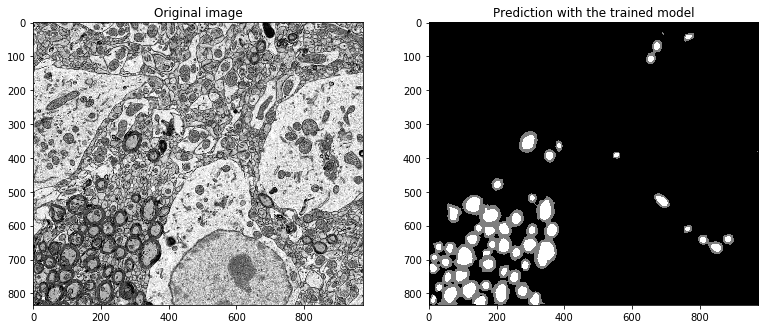

In [39]:
file_img_seg = 'AxonDeepSeg.png'  # axon+myelin segmentation
img_seg = imageio.imread(os.path.join(path_img, file_img_seg))
img = imageio.imread(os.path.join(path_img, file_img))

plt.figure(figsize=(13,10))
plt.subplot(121)
plt.title('Original image')
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.title('Prediction with the trained model')
plt.imshow(img_seg,cmap='gray')
plt.show()